In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random as rd
import time
import pandas as pd

## Community Detection

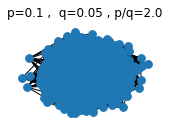

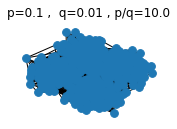

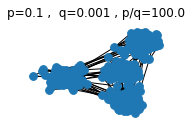

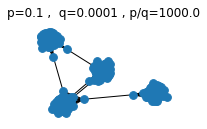

In [ ]:
def modularite(G,communities):   #critère de communauté
    m=0
    n = len(G)
    for i in range(n-1):
        for j in range(i+1,n):
            m+=G[i,j]
    Q=0
    list = n*[0]
    degree_list=[]
    for i in range(n):
        degree_list.append(degree(G,i))
    for c in communities:
        for i in range(len(c)):
            for j in range(len(c)):
                Q+= G[c[i],c[j]] - degree_list[c[i]]*degree_list[c[j]]/(2*m)
    Q=Q/(2*m)
    return Q

def random_graph(n,p,q):    #Graphes aléatoires avec des communautés de taille 100
    G=nx.Graph()
    G.add_nodes_from([k for k in range(n)])
    for i in range(n-1):
        for j in range(i+1,n):
            if j//100 == i//100:
                if rd.random()<p:
                    G.add_edge(i,j)
            else:
                if rd.random()<q:
                    G.add_edge(i,j)
    return G


def random_graph_draw(n,p,q):  # plot graphes
    G=nx.Graph()
    G.add_nodes_from([k for k in range(n)])
    for i in range(n-1):
        for j in range(i+1,n):
            if j//100 == i//100:
                if rd.random()<p:
                    G.add_edge(i,j)
            else:
                if rd.random()<q:
                    G.add_edge(i,j)
    plt.title("p="+str(p)+" ,  q="+str(q)+" , p/q="+str(p/q))
    nx.draw(G, node_size = 60)
    plt.show()


plt.figure(1)
plt.subplot(2,2,1)
random_graph_draw(400,0.1,0.05)
plt.subplot(2,2,2)
random_graph_draw(400,0.1,0.01)
plt.subplot(2,2,3)
random_graph_draw(400,0.1,0.001)
plt.subplot(2,2,4)
random_graph_draw(400,0.1,0.0001)

## Implémentation d'une variante de l'algorithme de Louvain

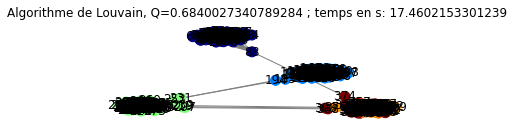

In [ ]:
#Implémentation de l'algorithme de Louvain, je choisis une représentation du graphe par matrice d'adjacence

def remove(L,x):
    newL=[]
    for y in L:
        if y != x:
            newL.append(y)
    return newL

def neighboor_com(G,C,s): #renvoie les communautés voisines de s
    nc=[]
    for k in range(len(C)):
        if not (s in C[k]):
            i = 1
            bool = False
            L=C[k]
            while i < len(L) and not bool:
                if G[s,L[i]] == 1:
                    bool = True
                else:
                    i+=1
            if bool:
                nc.append(L)
    return nc

def edges_in_community(G,com):
    s=0
    for x in com:
        for y in com:
            if G[x,y]==1:
                s+=1
    return s/2

def edges_link_community(G,com):
    s=0
    n=len(G)
    for i in range(n):
        for j in range(n):
            if i!=j:
                if G[i,j] == 1 and (i in com or j in com):
                    s+=1
    return s/2

def degree(G,s):
    d=0
    for k in range(len(G)):
        if k!=s and G[s,k]==1:
            d+=1
    return d

def degree_community(G,com,s):
    d=0
    for x in com[1::]:
        if G[s,x]==1:
            d+=1
    return d


def louvain(G): #G est la donnée d'une matrice d'adjacence
    n=len(G)
    C=[]
    for i in range(n):
        s_tot = degree(G,i)
        C.append([(0,s_tot),i])  #communautés avec pour premier terme un tuple (s_in,s_tot) pour conserver les paramètre pour le calcul de Q
    m=0
    for i in range(n-1):
        for j in range(i+1,n):
            m+=G[i,j]              #m est le nombre total d'arêtes
    change = True
    iter=0
    modular = -2
    modularitebis = -1
    while change and np.abs(modular - modularitebis)>10**(-3):
        modular = modularitebis
        iter+=1
        change = False
        for i in range(n):
            dQmax=0
            ind=-1
            nc = neighboor_com(G,C,i)
            k = degree(G,i)
            ind=0
            while (not i in C[ind]):
                ind+=1
            com=C[ind]
            (sin,stot) = com[0]
            deg_tot = 0
            voisins_i=0
            for k in range(1,len(com)):
                if com[k]!=i:
                    deg_tot += degree(G,com[k])
                    if G[i,com[k]]==1:
                        voisins_i+=1
            dQ1= -voisins_i/(2*m) + degree(G,i)/(2*m)**2*deg_tot
            for j in range(len(nc)):
                (s_in,s_tot) = nc[j][0]
                k_in = degree_community(G,nc[j],i)
                dQ = dQ1 + ((s_in+k_in)/(2*m) - ((s_tot+k)/(2*m))**2) - (s_in/(2*m) -(s_tot/(2*m))**2 - (k/(2*m))**2)
                if dQ > dQmax:
                    dQmax = dQ
                    ind = j
            if dQmax > 0:
                change = True
                ind_i=0         #on retire i de son ancienne communauté pour le mettre dans la nouvelle
                while not (i in C[ind_i]):
                    ind_i+=1
                newC=[]
                ind_max=0
                while C[ind_max] != nc[ind]:
                    ind_max+=1
                for l in range(len(C)):
                    if l == ind_i:                        #on met à jour les valeurs s_in et s_tot
                        if len(C[l]) > 2:
                            com=remove(C[l],i)
                            (sin,stot) = com[0]
                            sin = sin - degree_community(G,com,i)
                            stot = stot - degree(G,i) + degree_community(G,com,i)
                            com[0]=(sin,stot)
                            newC.append(com)
                    elif l == ind_max:
                        com = C[l]
                        (sin,stot) = com[0]
                        sin = sin + degree_community(G,com,i)
                        stot = stot + degree(G,i) -degree_community(G,com,i)
                        com = com+[i]
                        com[0]=(sin,stot)
                        newC.append(com)
                    else:
                        newC.append(C[l])
                C=newC
        Cbis=[]
        for i in range(len(C)):
            Cbis.append(C[i][1:])
        modularitebis = modularite(G,Cbis)
    for i in range(len(C)):
        C[i]=C[i][1:]
    return C

p=0.2
q=0.0001

G=random_graph(400,p,q)
G_adj = np.zeros((400,400))
for (i,j) in list(G.edges()):
    G_adj[i,j]=1
    G_adj[j,i]=1

plt.figure(1)

a=time.time()
communities = louvain(G_adj)
b=time.time()
dt= (b-a)
Q = modularite(G_adj,communities)

couleurs_num = [0] * 400
for i in range(len(communities)):
  for j in communities[i]:
    couleurs_num[j] = i
options = {
      'cmap'       : plt.get_cmap('jet'),
      'node_color' : couleurs_num,
      'node_size'  : 100,
      'edge_color' : 'tab:grey',
      'with_labels': True
    }
plt.subplot(2,1,1)
nx.draw(G,**options)
plt.title("Algorithme de Louvain, Q="+str(Q)+" ; temps en s: "+str(dt))
plt.show()

 Tentative d'algo basé sur le parcours en profondeur

on parcourt tous les voisins à distance moins de d et on associe la même couleur à tous ses sommets et on réïtere tant qu'il reste des sommets sans couleurs. Puis certains sommets auront plusieurs couleur donc on prend celle qui est présente chez le plus de leur voisin  (on cherche les k-club)

Le but ici est d'implémenter un algorithme rapide quitte à perdre en optimalité. Nécessite également de connaître la structure des communautés pour choisir la profondeur d'exploration.

In [ ]:
def bfs(G,s,L,n,n_lim):  #parcours en profondeur 
    nG=len(G)
    for k in range(nG):
        if G[s,k] == 1 and L[k]==0:
            L[k]=1
            if n<n_lim:
                bfs(G,k,L,n+1,n_lim)

def algo_com(G,d):
    n = len(G)
    L=n*[0]
    L[0]=1
    colors = n*[[]]
    c=0
    colors[0]= [0]
    while L != n*[1]:
        possibles = []
        for i in range(n):   # On choisit les noeuds de départ al&atoirement
            if L[i]==0:
                possibles.append(i)
        np = len(possibles)-1
        rand=rd.randint(0,np)
        ind = possibles[rand]
        Lbis=n*[0]
        Lbis[ind]=1
        bfs(G,ind,Lbis,0,d)
        for k in range(n):
            if Lbis[k]==1:
                L[k]=1
                colors[k] = colors[k]+[c]
        c+=1
    communities = c*[[]]
    for k in range(n):
        if len(colors[k])==1:
            communities[colors[k][0]] = communities[colors[k][0]] +[k]
        else:
            count = c*[0]
            for i in range(n):
                if G[i,k]==1:
                    for x in colors[i]:
                        if x in colors[k]:
                            count[x]= count[x]+1
            ind=0
            max=count[0]
            for i in range(c):
                if count[i]>max:
                    max = count[i]
                    ind = i
            communities[ind]=communities[ind]+[k] #on peut s'arêter ici, mais nous allons refaire des tours pour vérifier qu'un noeud a la même couleur qu'une majorité de ses voisins
    change = True
    iter=0
    while change:
        iter+=1
        change = False
        for i in range(n):
            count = c*[0]
            for j in range(n):
                if G[i,j]==1:
                    ind_com=0
                    while not (j in communities[ind_com]):
                        ind_com+=1
                    count[ind_com]=count[ind_com]+1
            ind=0
            max=count[0]
            for k in range(c):
                if count[k]>max:
                    max = count[k]
                    ind = k
            if not (i in communities[ind]):
                change = True
                ind_com=0
                while not (i in communities[ind_com]):
                    ind_com+=1
                communities[ind]=communities[ind]+[i]
                if len(communities[ind_com])==1:
                    communities = remove(communities,communities[ind_com])
                else:
                    communities[ind_com]=remove(communities[ind_com],i)
    return communities

0
1
2


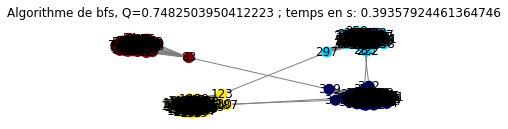

In [ ]:
p=0.2
q=0.0001

G=random_graph(400,p,q)
G_adj = np.zeros((400,400))
for (i,j) in list(G.edges()):
    G_adj[i,j]=1
    G_adj[j,i]=1

plt.figure(1)

a=time.time()
communities = algo_com(G_adj,1)
b=time.time()
dt= (b-a)
Q = modularite(G_adj,communities)

couleurs_num = [0] * 400
for i in range(len(communities)):
  for j in communities[i]:
    couleurs_num[j] = i
options = {
      'cmap'       : plt.get_cmap('jet'),
      'node_color' : couleurs_num,
      'node_size'  : 100,
      'edge_color' : 'tab:grey',
      'with_labels': True
    }
plt.subplot(2,1,1)
nx.draw(G,**options)
plt.title("Algorithme de bfs, Q="+str(Q)+" ; temps en s: "+str(dt))
plt.show()

Nouvelle idée pour améliorer mon algo par parcours en profondeur.
 On peut s'inspirer de l'idée principale de l'algorithme LICOD : on repère des "leaders" i.e des noeuds qui ont une centralité plus grande que celle de tous leurs voisins, et on fait partir notre parcours en profondeur de ces points la plutôt que de les prendre de manière aléatoire.


Algo de détection de leader : leader ssi plus gros degré que ses voisins.

In [ ]:
def leader_degree(G):
    leaders=[]
    n = len(G)
    list = n*[0]
    degree_list=[]
    for i in range(n):
        degree_list.append(degree(G,i))
    for i in range(n):
        if list[i]==0:
            list[i]=1
            d = degree_list[i]
            dmax=0
            ind=0
            while dmax <= d and ind<n:
                if ind != i and G[i,ind]==1:
                    deg = degree_list[ind]
                    if deg > dmax:
                        dmax = deg
                ind+=1
            if dmax <= d:
                leaders.append(i)
                for j in range(n):
                    if G[i,j]==1:
                        list[j]=1     #les voisins d'un leader ne peuvent être des leaders
    return leaders

#On pourrait aussi utiliser la centralité d'intermédiarité : le nombre de fois où une arête intervient dans le chemin le plus court entre 2 noeuds : contraire à notre idée d'aller vite !

def algo_leader(G,d):
    n = len(G)
    L=n*[0]
    L[0]=1
    colors = n*[[]]
    c=0
    colors[0]= [0]
    leaders = leader_degree(G)
    while L != n*[1]:
        if leaders != []:
            nl = len(leaders) - 1
            rand=rd.randint(0,nl)
            ind = leaders[rand]
            Lbis=n*[0]
            Lbis[ind]=1
            bfs(G,ind,Lbis,0,d)
            for k in range(n):
                if Lbis[k]==1:
                    L[k]=1
                    colors[k] = colors[k]+[c]
            c+=1
            leaders=remove(leaders,ind)
        else:
            possibles = []
            for i in range(n):   # On choisit les noeuds de départ al&atoirement
                if L[i]==0:
                    possibles.append(i)
            np = len(possibles)-1
            rand=rd.randint(0,np)
            ind = possibles[rand]
            Lbis=n*[0]
            Lbis[ind]=1
            bfs(G,ind,Lbis,0,d)
            for k in range(n):
                if Lbis[k]==1:
                    L[k]=1
                    colors[k] = colors[k]+[c]
            c+=1
    communities = c*[[]]
    for k in range(n):
        if len(colors[k])==1:
            communities[colors[k][0]] = communities[colors[k][0]] +[k]
        else:
            count = c*[0]
            for i in range(n):
                if G[i,k]==1:
                    for x in colors[i]:
                        if x in colors[k]:
                            count[x]= count[x]+1
            ind=0
            max=count[0]
            for i in range(c):
                if count[i]>max:
                    max = count[i]
                    ind = i
            communities[ind]=communities[ind]+[k] #on peut s'arêter ici, mais nous allons refaire des tours pour vérifier qu'un noeud a la même couleur qu'une majorité de ses voisins
    change = True
    while change:
        change = False
        for i in range(n):
            count = c*[0]
            for j in range(n):
                if G[i,j]==1:
                    ind_com=0
                    while not (j in communities[ind_com]):
                        ind_com+=1
                    count[ind_com]=count[ind_com]+1
            ind=0
            max=count[0]
            for k in range(c):
                if count[k]>max:
                    max = count[k]
                    ind = k
            if not (i in communities[ind]):
                change = True
                ind_com=0
                while not (i in communities[ind_com]):
                    ind_com+=1
            if not (i in communities[ind]):
                change = True
                ind_com=0
                while not (i in communities[ind_com]):
                    ind_com+=1
                communities[ind]=communities[ind]+[i]
                if len(communities[ind_com])==1:
                    communities = remove(communities,communities[ind_com])
                else:
                    communities[ind_com]=remove(communities[ind_com],i)
    return communities

## Exemple 3 algos sur graphes aléatoires

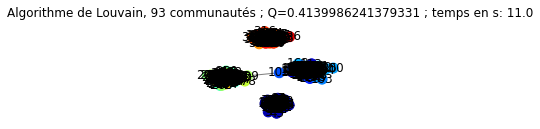

0
1
2
3
4
5
6


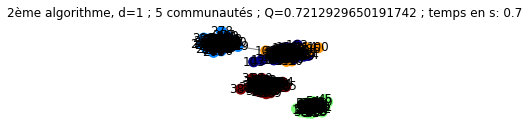

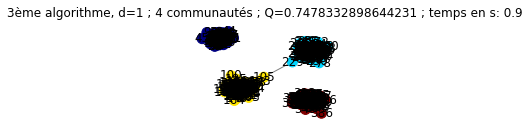

In [ ]:
p=0.05
q=0.00001

G=random_graph(400,p,q)
G_adj = np.zeros((400,400))
for (i,j) in list(G.edges()):
    G_adj[i,j]=1
    G_adj[j,i]=1

plt.figure(1)

a=time.time()
communities = louvain(G_adj)
b=time.time()
dt= (((b-a)*100)//10)/10
Q = modularite(G_adj,communities)


couleurs_num = [0] * 400
for i in range(len(communities)):
  for j in communities[i]:
    couleurs_num[j] = i
options = {
      'cmap'       : plt.get_cmap('jet'),
      'node_color' : couleurs_num,
      'node_size'  : 100,
      'edge_color' : 'tab:grey',
      'with_labels': True
    }
plt.subplot(2,2,1)
nx.draw(G,**options)
plt.title("Algorithme de Louvain, "+str(len(communities))+" communautés ; Q="+str(Q)+" ; temps en s: "+str(dt))
plt.show()

a=time.time()
communities = algo_com(G_adj,1)
b=time.time()
dt= (((b-a)*100)//10)/10
Q = modularite(G_adj,communities)

couleurs_num = [0] * 400
for i in range(len(communities)):
  for j in communities[i]:
    couleurs_num[j] = i
options = {
      'cmap'       : plt.get_cmap('jet'),
      'node_color' : couleurs_num,
      'node_size'  : 100,
      'edge_color' : 'tab:grey',
      'with_labels': True
    }
plt.subplot(2,2,2)
nx.draw(G,**options)
plt.title("2ème algorithme, d=1 ; "+str(len(communities))+" communautés ; Q="+str(Q)+" ; temps en s: "+str(dt))
plt.show()

a=time.time()
communities = algo_leader(G_adj,1)
b=time.time()
dt= (((b-a)*100)//10)/10
Q = modularite(G_adj,communities)

couleurs_num = [0] * 400
for i in range(len(communities)):
  for j in communities[i]:
    couleurs_num[j] = i
options = {
      'cmap'       : plt.get_cmap('jet'),
      'node_color' : couleurs_num,
      'node_size'  : 100,
      'edge_color' : 'tab:grey',
      'with_labels': True
    }
plt.subplot(2,2,3)
nx.draw(G,**options)
plt.title("3ème algorithme, d=1 ; "+str(len(communities))+" communautés ; Q="+str(Q)+" ; temps en s: "+str(dt))
plt.show()

## Test sur vrai graphe des citations sur les articles de physique

0
1
2
3
4
5
6
7
8


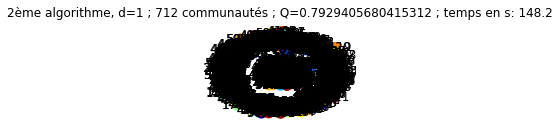

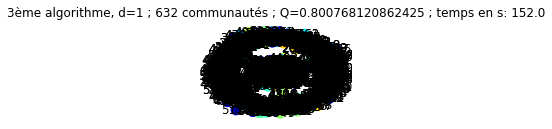

In [ ]:
data = pd.read_csv("CA-GrQc.txt",delimiter = "\t",header = None)

id_vertices = []

for k in range(len(data)):
  i = data.iloc[k,0]
  j = data.iloc[k,1]
  if not i in id_vertices:
    id_vertices.append(i)
  if not j in id_vertices:
    id_vertices.append(j)

def position(x,L):
    ind=0
    while L[ind]!=x:
        ind+=1
    return ind

n_nodes=5242

G_adj=np.zeros((n_nodes,n_nodes))

for k in range(len(data)):
  i = data.iloc[k,0]
  j = data.iloc[k,1]
  i,j = position(i,id_vertices), position(j,id_vertices)
  G_adj[i,j]=1
  G_adj[j,i]=1

G=nx.Graph()
G.add_nodes_from([k for k in range(n_nodes)])
for i in range(n_nodes):
  for j in range(i+1,n_nodes):
    if G_adj[i,j]==1:
      G.add_edge(i,j)

a=time.time()
communities = algo_com(G_adj,1)
b=time.time()
dt= (((b-a)*100)//10)/10
Q = modularite(G_adj,communities)

couleurs_num = [0] * n_nodes
for i in range(len(communities)):
  for j in communities[i]:
    couleurs_num[j] = i
options = {
      'cmap'       : plt.get_cmap('jet'),
      'node_color' : couleurs_num,
      'node_size'  : 100,
      'edge_color' : 'tab:grey',
      'with_labels': True
    }
plt.subplot(2,2,2)
nx.draw(G,**options)
plt.title("2ème algorithme, d=1 ; "+str(len(communities))+" communautés ; Q="+str(Q)+" ; temps en s: "+str(dt))
plt.show()

a=time.time()
communities = algo_leader(G_adj,1)
b=time.time()
dt= (((b-a)*100)//10)/10
Q = modularite(G_adj,communities)

couleurs_num = [0] * n_nodes
for i in range(len(communities)):
  for j in communities[i]:
    couleurs_num[j] = i
options = {
      'cmap'       : plt.get_cmap('jet'),
      'node_color' : couleurs_num,
      'node_size'  : 100,
      'edge_color' : 'tab:grey',
      'with_labels': True
    }
plt.subplot(2,2,3)
nx.draw(G,**options)
plt.title("3ème algorithme, d=1 ; "+str(len(communities))+" communautés ; Q="+str(Q)+" ; temps en s: "+str(dt))
plt.show()